# **Introduction**

**L'étude du Produit Intérieur Brut (PIB) est fondamentale pour comprendre la dynamique économique d'un pays sur une période donnée. Selon François Perroux, économiste français de renom, le PIB représente « la somme des valeurs ajoutées marchandes et non marchandes créées au cours d'une année sur le territoire national ». Cette définition met en lumière l'importance du PIB comme mesure synthétique reflétant l'activité économique globale.**

**Cependant, les courants de pensée économique divergent quant à la pertinence et aux limites du PIB. D'une part, l'école classique et néoclassique considère le PIB comme un indicateur central et indispensable pour évaluer la croissance économique, la santé d'une économie et orienter les politiques publiques. D'autre part, les courants critiques et post-croissance dénoncent les insuffisances de cet indicateur, qui ne prend pas en compte le bien-être, les inégalités, ni les impacts environnementaux de la croissance économique.**

**Le problème posé par cette étude est donc double : comment interpréter l'évolution du PIB à la lumière de ces débats économiques ? Quels enseignements peut-on tirer d'une analyse approfondie tant quantitative que qualitative de ces données pour mieux comprendre les transformations économiques ?**

**Pour répondre à ces questions, l'étude se concentrera sur l'analyse statistique descriptive du PIB américain, l'examen des séries temporelles. En particulier, la méthode Hot Winter sera mobilisée afin d'explorer les relations dynamiques entre variables économiques au fil du temps. Cette approche méthodologique permettra de saisir les tendances, ruptures et influences structurelles du PIB américain sur une période de 50 ans, intégrant ainsi une perspective critique sur la croissance économique.**

## **I-Importation,nettoyage et exploration des données**

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

from scipy.stats import norm, shapiro, kurtosis, skew
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import missingno as msno

### **- Importation des données**

In [38]:
pib = pd.read_csv("gdp_data.csv")
pib = pib.rename(columns = {'GDP':'PIB'})
pib

,DATE,PIB
0,1974-01-01,1491.209
1,1974-04-01,1530.056
2,1974-07-01,1560.026
3,1974-10-01,1599.679
4,1975-01-01,1616.116
...,...,...
196,2023-01-01,26813.601
197,2023-04-01,27063.012
198,2023-07-01,27610.128
199,2023-10-01,27956.998


Nous sommes en présence de données économiques notamment celui du PIB américain de 1974-2024. il comprend 201 périodes décomposé en trimestre par Année et deux colonnes dont une colonne date allant de 1974 à 2024 et une colonne PIB.

### **- Nettoyage**

**Doublons**

In [39]:
duplicated_rows = pib['DATE'].duplicated()
nombre_doublons = duplicated_rows.sum()

print("Nombre de doublons :", nombre_doublons)

Nombre de doublons : 0


**Valeurs manquantes**

In [40]:
nombre_valeurs_manquantes = pib.isna().sum().sum()
print("Nombre de valeurs manquantes :", nombre_valeurs_manquantes)

Nombre de valeurs manquantes : 0


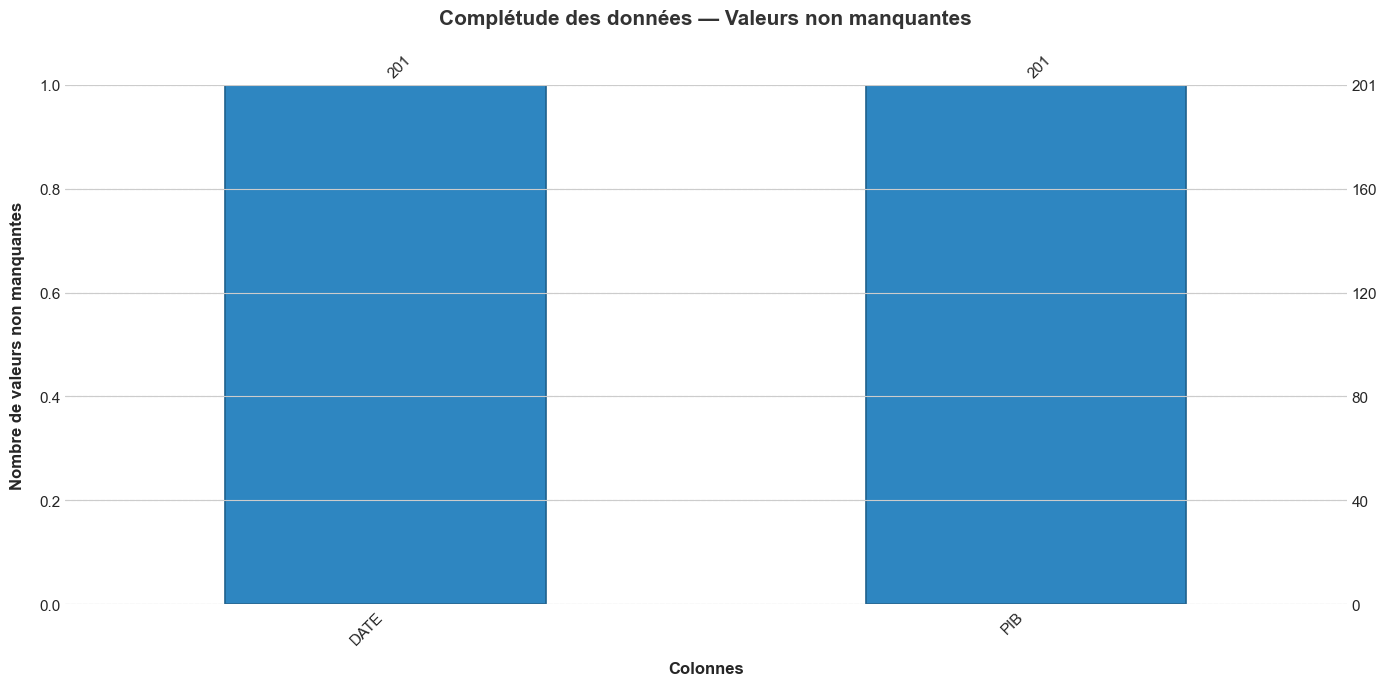

In [41]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

ax = msno.bar(
    pib,
    figsize=(14, 7),
    color='#2E86C1',       
    fontsize=11,
    labels=True,           
    log=False              
)

ax.set_title("Complétude des données — Valeurs non manquantes",
             fontsize=15, fontweight='bold', pad=20, color='#333333')
ax.set_xlabel("Colonnes", fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel("Nombre de valeurs non manquantes", fontsize=12, fontweight='bold', labelpad=10)

for patch in ax.patches:
    patch.set_edgecolor('#1F618D')   
    patch.set_linewidth(1.2)

ax.grid(axis='y', linestyle='--', alpha=0.6, color='#aaaaaa')
ax.set_axisbelow(True) 

plt.tight_layout()
plt.show()

# **II- Analyse descriptives de la serie temporelle**

### **1) Construction de la serie temporelle**

In [42]:
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

pib['Date_tri'] = pd.date_range(start = "1974-01", periods = len(pib), freq = 'Q')
pib['DATE'] = pib['Date_tri'].dt.year
pib.set_index("Date_tri", inplace = True)

In [43]:
pib.head()

,DATE,PIB
Date_tri,,
1974-03-31,1974,1491.209
1974-06-30,1974,1530.056
1974-09-30,1974,1560.026
1974-12-31,1974,1599.679
1975-03-31,1975,1616.116


### **- Structure de l’objet**

In [44]:
pib.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 201 entries, 1974-03-31 to 2024-03-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    201 non-null    int32  
 1   PIB     201 non-null    float64
dtypes: float64(1), int32(1)
memory usage: 3.9 KB


**- Le type de chaque colonne : numérique**

**- Le nombre de valeurs non nulles : 201 non-null**

**- La mémoire utilisée : 12.0 KB**

**- L’index et sa fréquence : 201 entries, 1974-03-31 to 2024-03-31**

### **- Métadonnées de l’objet**

In [45]:
pib.attrs 
print("Index :", pib.index)
print("Colonnes :", pib.columns)
print("Types :", pib.dtypes)

Index : DatetimeIndex(['1974-03-31', '1974-06-30', '1974-09-30', '1974-12-31',
               '1975-03-31', '1975-06-30', '1975-09-30', '1975-12-31',
               '1976-03-31', '1976-06-30',
               ...
               '2021-12-31', '2022-03-31', '2022-06-30', '2022-09-30',
               '2022-12-31', '2023-03-31', '2023-06-30', '2023-09-30',
               '2023-12-31', '2024-03-31'],
              dtype='datetime64[ns]', name='Date_tri', length=201, freq=None)
Colonnes : Index(['DATE', 'PIB'], dtype='object')
Types : DATE      int32
PIB     float64
dtype: object


### **-Statistiques descriptives**

In [46]:
a = pib.drop("DATE", axis = 1)
a.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PIB,201.0,10767.185687,7074.040546,1491.209,4607.669,9411.682,15647.68,28269.174


Entre 1974 et 2025, le PIB des États-Unis est passé de 1 491 à plus de 28 000 milliards de dollars. Malgré les crises majeures comme le choc pétrolier des années 70, la crise financière de 2008 ou la pandémie de COVID-19, l’économie américaine a su rebondir à chaque fois. Dans les années 80 et 90, la déréglementation et l’essor technologique ont donné naissance à la Silicon Valley, transformant profondément le tissu économique. Plus récemment, les plans de relance post-COVID et les investissements dans les infrastructures et la transition énergétique ont permis aux États-Unis de maintenir leur dynamique, tout en se repositionnant comme leader dans les technologies vertes. Cette trajectoire montre une chose : les États-Unis ont su transformer les défis en leviers de croissance. PIB d'où cette croissance.

### **2) Graphiques**

### **Serie temporelle**

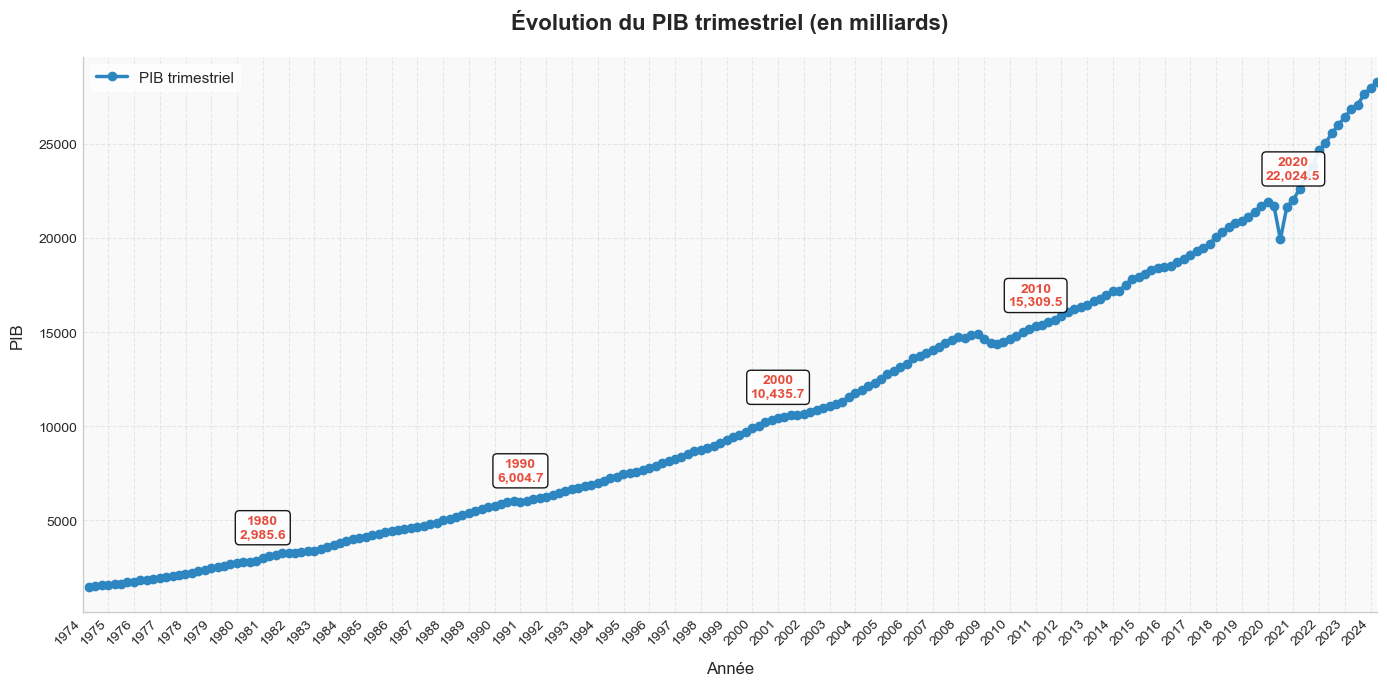

In [47]:
plt.figure(figsize=(14, 7))

plt.plot(pib.index, pib['PIB'],
         color='#2E86C1', linewidth=2.5, label='PIB trimestriel', marker='o', markersize=6)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

plt.title("Évolution du PIB trimestriel (en milliards)", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("Année", fontsize=12, labelpad=10)
plt.ylabel("PIB", fontsize=12, labelpad=10)

plt.grid(True, linestyle='--', alpha=0.6, color='#D5DBDB')
plt.gca().set_facecolor('#F9F9F9')

plt.legend(loc='upper left', frameon=True, facecolor='white', edgecolor='white')

plt.tick_params(axis='both', which='major', labelsize=10)

start_year = pib.index.min().year
end_year = pib.index.max().year
plt.gca().set_xlim([pib.index.min(), pib.index.max()])
plt.xticks([f"{year}-01-01" for year in range(start_year, end_year + 1)],
           [str(year) for year in range(start_year, end_year + 1)],
           rotation=45, ha='right')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

for year in range(start_year, end_year + 1):
    if year % 10 == 0: 
        year_data = pib[pib.index.year == year]
        if not year_data.empty:
            last_value = year_data['PIB'].iloc[-1]
            last_date = year_data.index[-1]
            plt.annotate(f'{year}\n{last_value:,.1f}',
                         xy=(last_date, last_value),
                         xytext=(0, 15), textcoords='offset points',
                         ha='center', fontsize=10, color='#E74C3C', 
                         bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9),
                         fontweight='bold')

plt.tight_layout()
plt.show()

### **Histogramme**

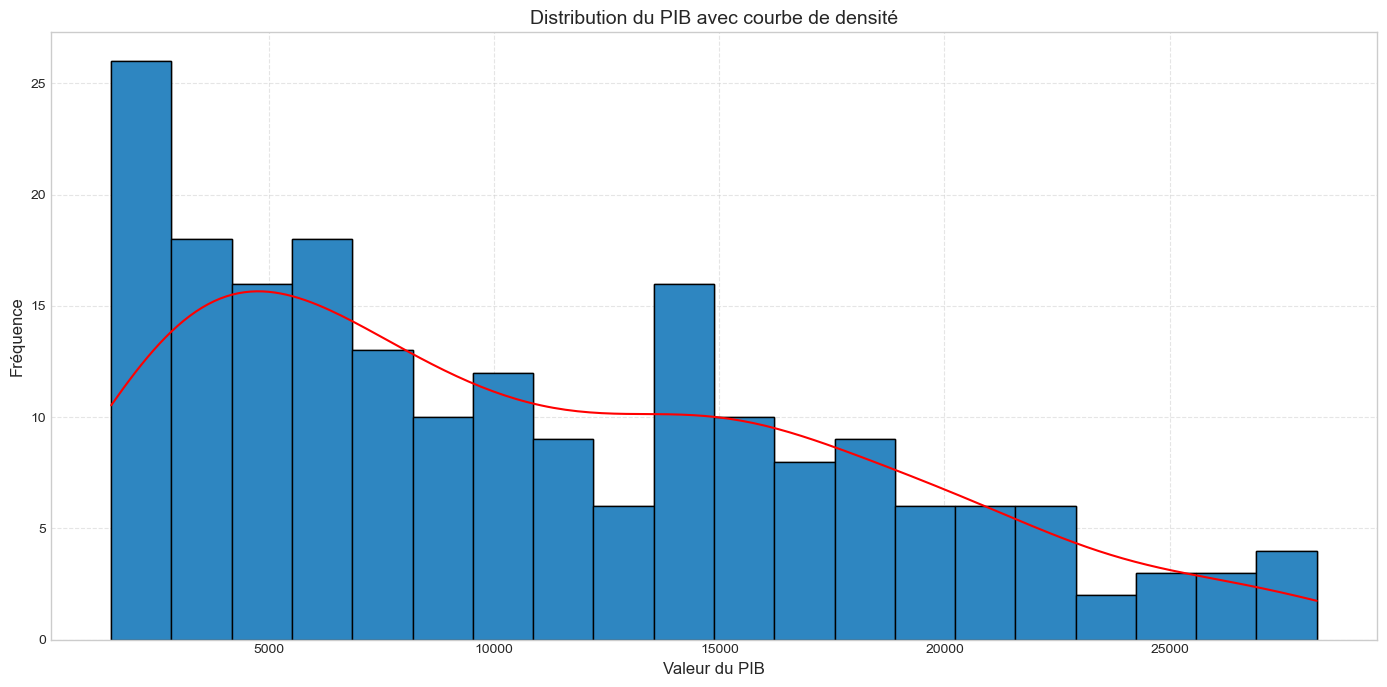

In [48]:
plt.figure(figsize=(14, 7))

sns.histplot(pib['PIB'].dropna(), bins=20, kde=True, color='red', edgecolor='black')

plt.title("Distribution du PIB avec courbe de densité", fontsize=14)
plt.hist(pib['PIB'], bins=20, color='#2E86C1', edgecolor='black')
plt.xlabel("Valeur du PIB", fontsize=12)
plt.ylabel("Fréquence", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### **Boxplot**

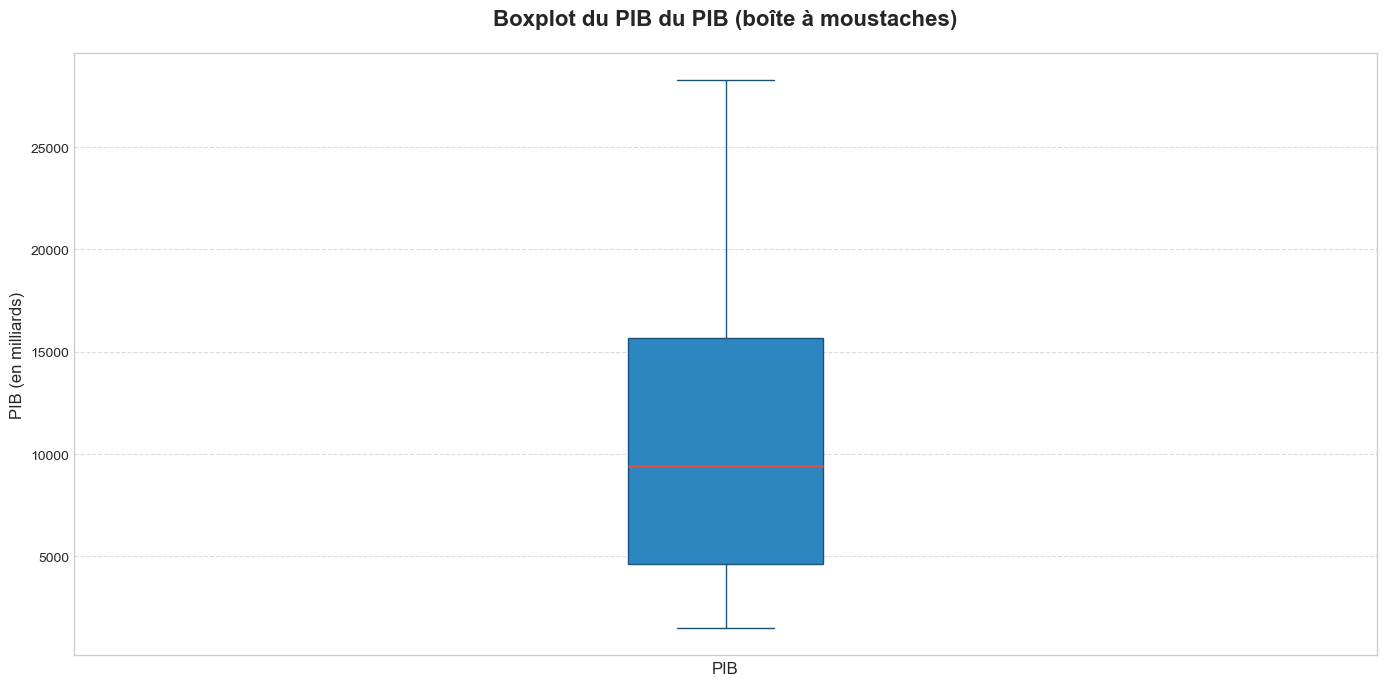

In [49]:
plt.figure(figsize=(14, 7))
plt.boxplot(a, 
            vert=True,
            patch_artist=True,
            boxprops=dict(facecolor='#2E86C1', color='#1A5276'),
            whiskerprops=dict(color='#1A5276'),
            capprops=dict(color='#1A5276'),
            medianprops=dict(color='#E74C3C', linewidth=2),
            flierprops=dict(marker='o', markerfacecolor='#E74C3C', markersize=6, alpha=0.5))

plt.title("Boxplot du PIB du PIB (boîte à moustaches)", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("PIB", fontsize=12)
plt.ylabel("PIB (en milliards)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks([])

plt.tight_layout()
plt.show()

### **3) INDICES STATISTIQUES**

#### **a) Indices de tendance centrale**

In [50]:
a.mean()

PIB    10767.185687
dtype: float64

#### **b) Indices de dispersion**

In [51]:
a.var()

PIB    5.004205e+07
dtype: float64

In [52]:
a.std()

PIB    7074.040546
dtype: float64

#### **c) Indices de formes**

In [53]:
serie_pib = a['PIB']
kurtosis_pib = kurtosis(serie_pib, bias=False) 
skewness_pib = skew(serie_pib, bias=False)  

print(f"Kurtosis (Aplatissement) : {kurtosis_pib:.4f}")
print(f"Skewness (Asymétrie) : {skewness_pib:.4f}")

Kurtosis (Aplatissement) : -0.6448
Skewness (Asymétrie) : 0.5761


#### **d) Indices de dépendance**

##### **- Autocorrélation** 

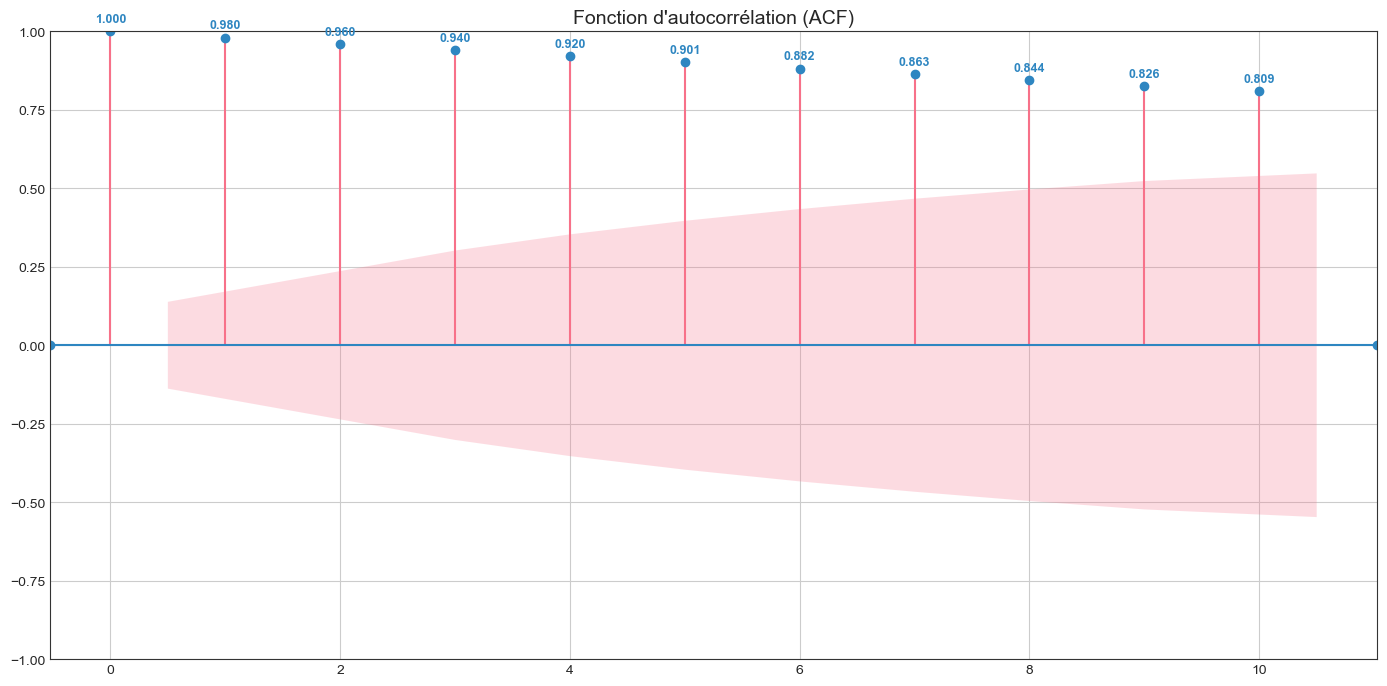

In [54]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 0.8

fig, ax = plt.subplots(figsize=(14, 7))

plot_acf(
    a.dropna(),
    lags=10,
    alpha=0.05,
    ax=ax,
    color='#2E86C1',  
    marker='o',       
    markersize=6,     
    linewidth=1.5,    
    title="Fonction d'autocorrélation (ACF)",
    missing='drop'
)

from statsmodels.tsa.stattools import acf
acf_values = acf(a.dropna(), nlags=10, fft=False)  

for i, v in enumerate(acf_values):
    ax.text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=9, color='#2E86C1', fontweight='bold')

plt.tight_layout()
plt.show()


##### **- Autocorrélation Partielle**

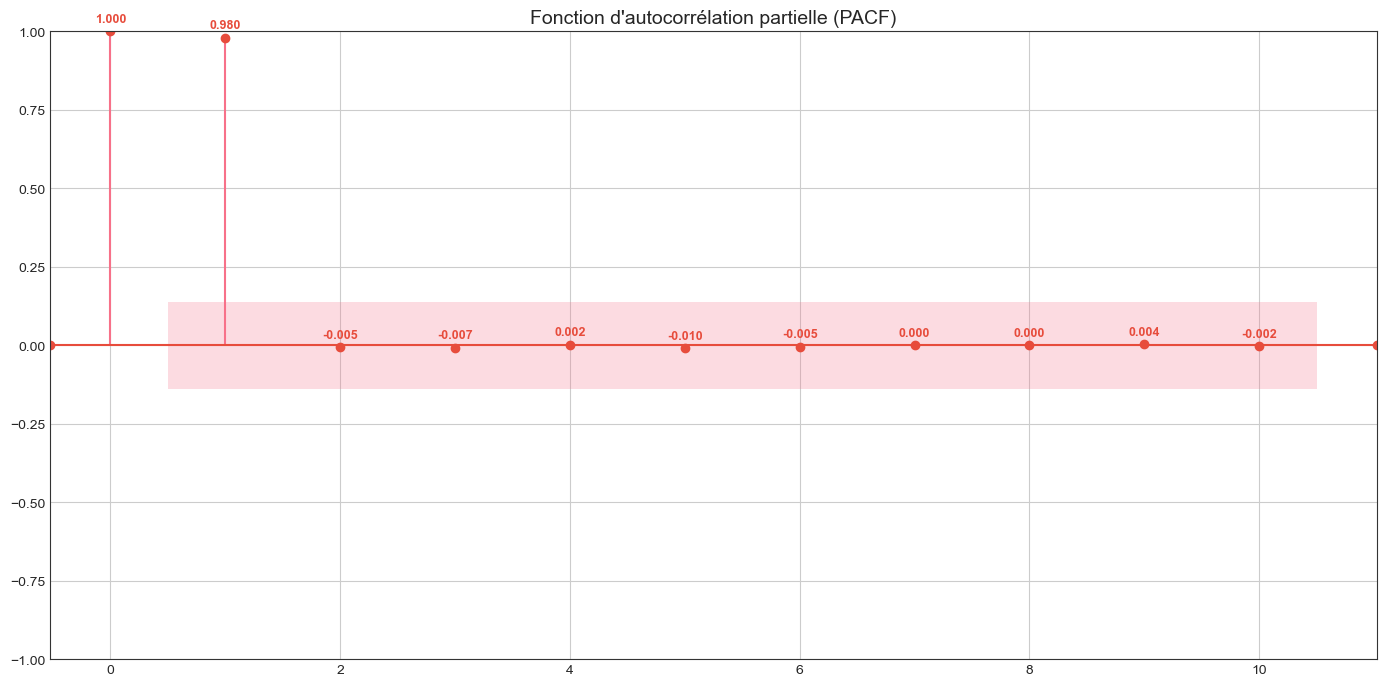

In [55]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 0.8


fig, ax = plt.subplots(figsize=(14, 7))

plot_pacf(
    a.dropna(),
    lags=10,
    alpha=0.05,
    ax=ax,
    method='ywm',      
    color='#E74C3C',   
    marker='o',
    markersize=6,
    linewidth=1.5,
    title="Fonction d'autocorrélation partielle (PACF)"
)

pacf_values = pacf(a.dropna(), nlags=10, method='ywm') 

for i, v in enumerate(pacf_values):
    ax.text(i, v + 0.02, f"{v:.3f}", 
            ha='center', va='bottom', 
            fontsize=9, color='#E74C3C', fontweight='bold')

plt.tight_layout()
plt.show()

# **III- Lissage exponentielle et Hotwinter**

En règle générale, sous Python on laisse l’algorithme lui-même calculer les valeurs optimales de : alpha, beta et gamma

In [56]:
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

model = ExponentialSmoothing(
    a,
    trend='add',
    seasonal=None,
    initialization_method='estimated'
)

fitted_model = model.fit()

print("📊 Résumé du modèle Holt-Winters (lissage exponentiel)")
print("="*60)
print(f"Alpha (niveau)     : {fitted_model.params['smoothing_level']:.5f}")
print(f"Beta (tendance)    : {fitted_model.params['smoothing_trend']:.5f}")
print(f"SSE (erreur)       : {fitted_model.sse:,.2f}")
print(f"Nombre d'obs.      : {len(a)}")
if isinstance(a.index, pd.DatetimeIndex):
    print(f"Date début/fin     : {a.index[0]} → {a.index[-1]}")


📊 Résumé du modèle Holt-Winters (lissage exponentiel)
Alpha (niveau)     : 0.87714
Beta (tendance)    : 0.08771
SSE (erreur)       : 8,675,867.69
Nombre d'obs.      : 201
Date début/fin     : 1974-03-31 00:00:00 → 2024-03-31 00:00:00


#### **-Valeurs lissées**

In [57]:
valeurs_lissees = fitted_model.fittedvalues
valeurs_lissees

Date_tri
1974-03-31     1477.750655
1974-06-30     1530.944392
1974-09-30     1571.485640
1974-12-31     1601.872712
1975-03-31     1640.218547
                  ...     
2023-03-31    26758.881677
2023-06-30    27170.895939
2023-09-30    27431.983541
2023-12-31    27957.664980
2024-03-31    28326.451927
Length: 201, dtype: float64

#### **- Visualisation du Lissage exponentiel** 

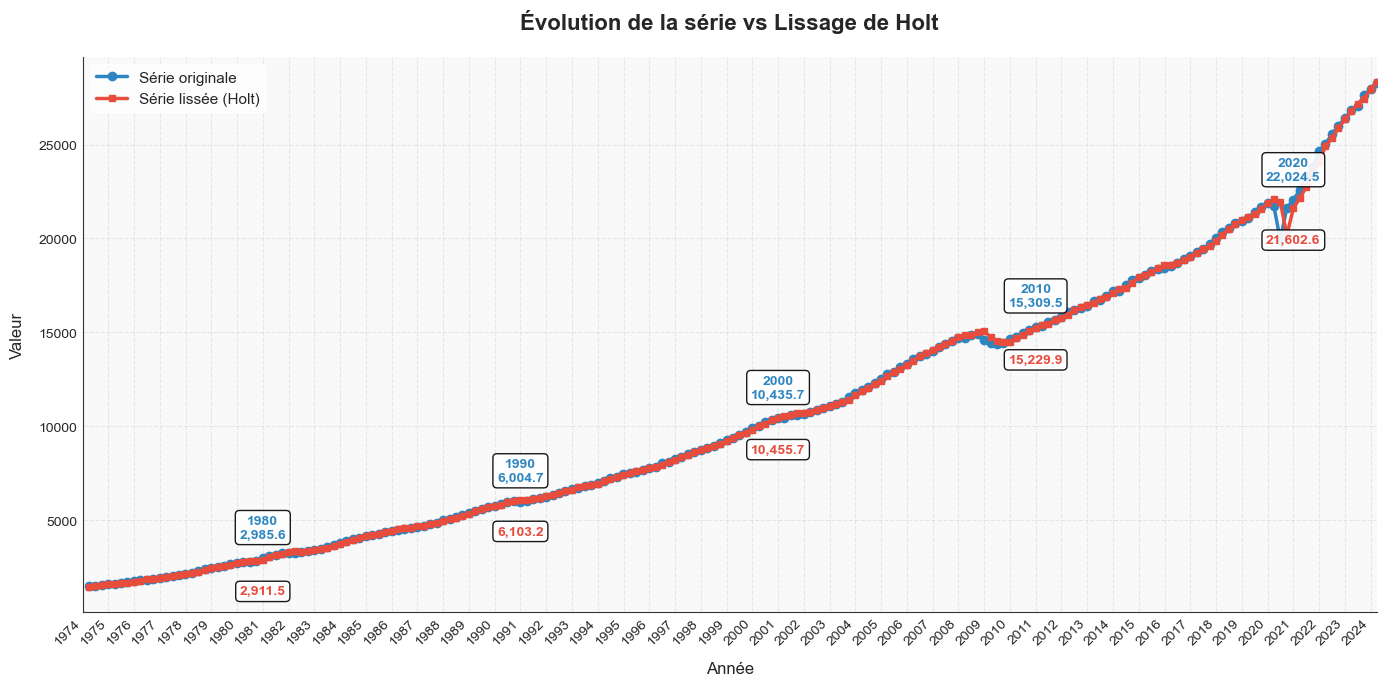

In [58]:
warnings.filterwarnings("ignore", category=UserWarning)     
warnings.filterwarnings("ignore", category=FutureWarning)   
plt.rcParams.update({'figure.max_open_warning': 0})          

plt.figure(figsize=(14, 7))

plt.plot(a.index, a,
         color='#2E86C1', linewidth=2.5, label='Série originale', marker='o', markersize=6)

plt.plot(a.index, fitted_model.fittedvalues,
         color='#E74C3C', linewidth=2.5, label='Série lissée (Holt)', marker='s', markersize=5)

if isinstance(a.index, pd.DatetimeIndex):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gcf().autofmt_xdate()

plt.title("Évolution de la série vs Lissage de Holt", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("Année", fontsize=12, labelpad=10)
plt.ylabel("Valeur", fontsize=12, labelpad=10)

plt.grid(True, linestyle='--', alpha=0.6, color='#D5DBDB')
plt.gca().set_facecolor('#F9F9F9')

plt.legend(loc='upper left', frameon=True, facecolor='white', edgecolor='white', fontsize=11)

plt.tick_params(axis='both', which='major', labelsize=10)

if isinstance(a.index, pd.DatetimeIndex):
    start_year = a.index.min().year
    end_year = a.index.max().year
    plt.gca().set_xlim([a.index.min(), a.index.max()])


    tick_dates = []
    tick_labels = []
    for year in range(start_year, end_year + 1):
        try:
            tick_date = pd.Timestamp(f"{year}-01-01")
            tick_dates.append(tick_date)
            tick_labels.append(str(year))
        except:
            continue 

    if tick_dates:
        plt.xticks(tick_dates, tick_labels, rotation=45, ha='right')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

if isinstance(a.index, pd.DatetimeIndex):
    start_year = a.index.min().year
    end_year = a.index.max().year

    for year in range(start_year, end_year + 1):
        if year % 10 == 0:
           
            year_mask = a.index.year == year

            if year_mask.sum() > 0:
                try:
                    last_orig_value = float(a[year_mask].iloc[-1])
                    last_orig_date = a[year_mask].index[-1]

                    plt.annotate(f'{year}\n{last_orig_value:,.1f}',
                                 xy=(last_orig_date, last_orig_value),
                                 xytext=(0, 15), textcoords='offset points',
                                 ha='center', fontsize=10, color='#2E86C1',
                                 bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9),
                                 fontweight='bold')

                    smooth_slice = fitted_model.fittedvalues[year_mask]
                    if len(smooth_slice) > 0:
                        last_smooth_value = float(smooth_slice.iloc[-1])
                        last_smooth_date = smooth_slice.index[-1]

                        plt.annotate(f'{last_smooth_value:,.1f}',
                                     xy=(last_smooth_date, last_smooth_value),
                                     xytext=(0, -25), textcoords='offset points',
                                     ha='center', fontsize=10, color='#E74C3C',
                                     bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9),
                                     fontweight='bold')

                except Exception:
                    continue

plt.tight_layout()
plt.show()

# **IV- Validation du modèle de lissage par l’analyse des résidus** 

Il s’agit de vérifier si les résidus du modèle choisi suivent un processus bruit blanc (nous verrons cela en détail 
dans le modèle ARIMA). Dans le cas contraire, le modèle n’est pas bon. Il va falloir choisir un autre ou 
reprendre les étapes précédentes. La satisfaction de la seule condition de bruit blanc suffit pour valider le 
modèle. Mais si les résidus suivent en plus un processus gaussien (loi normal), le modèle serait encore plus 
intéressant

### **- Récupérer les résidus**

In [59]:
residus = fitted_model.resid

print("📉 Résidus du modèle de lissage exponentiel :")
print(residus)

📉 Résidus du modèle de lissage exponentiel :
Date_tri
1974-03-31     13.458345
1974-06-30     -0.888392
1974-09-30    -11.459640
1974-12-31     -2.193712
1975-03-31    -24.102547
                 ...    
2023-03-31     54.719323
2023-06-30   -107.883939
2023-09-30    178.144459
2023-12-31     -0.666980
2024-03-31    -57.277927
Length: 201, dtype: float64


### **Graphe**

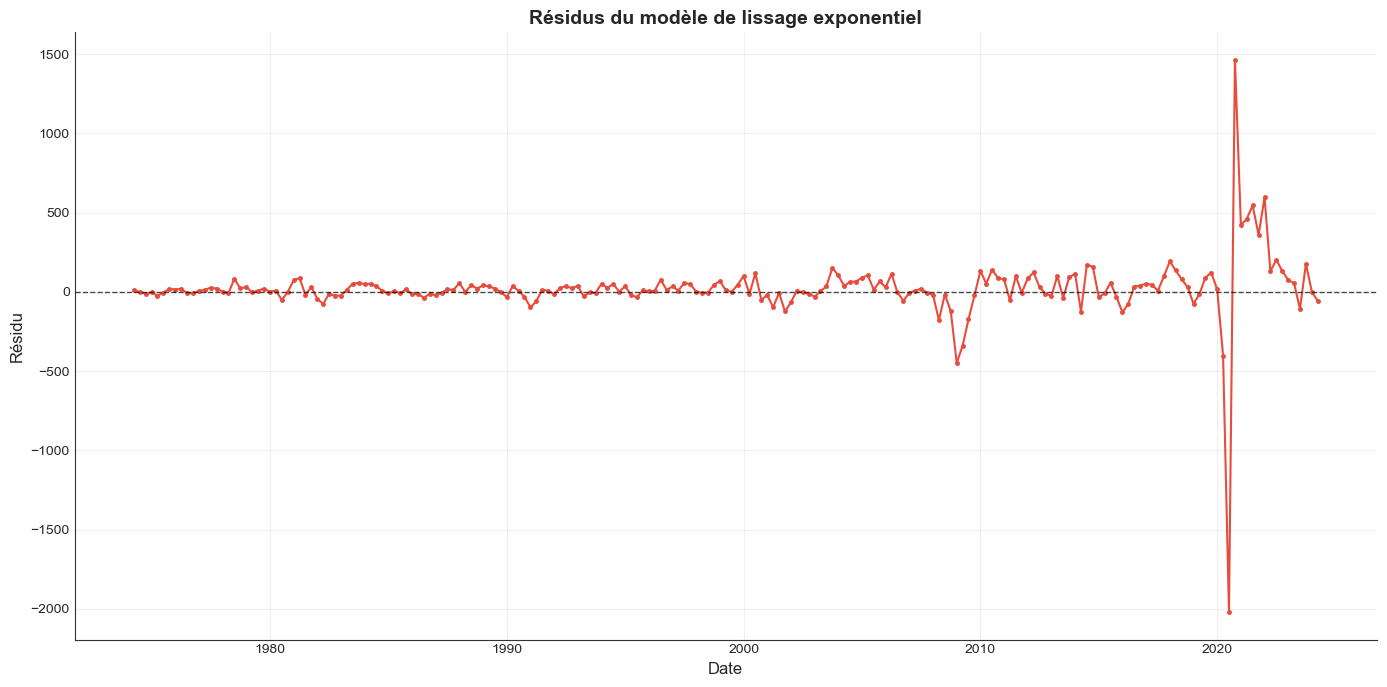

In [60]:
plt.figure(figsize=(14, 7))
plt.plot(residus.index, residus, color='#E74C3C', marker='.', linestyle='-', linewidth=1.5, markersize=5)
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.title("Résidus du modèle de lissage exponentiel", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Résidu")
plt.grid(True, alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

### **- BRUIT BLANC (Test de Ljung-Box)** 

<Figure size 1400x700 with 0 Axes>

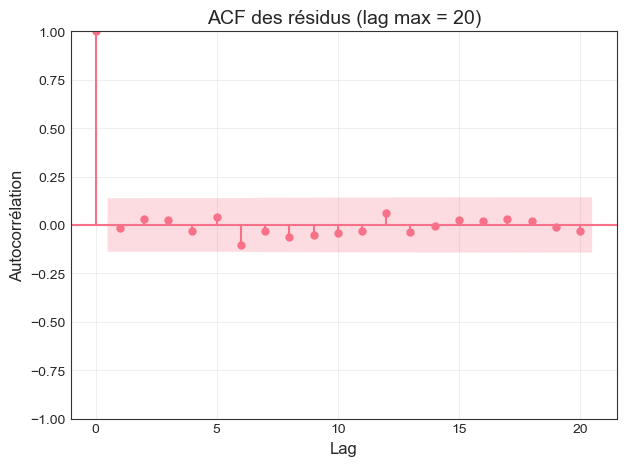

In [61]:
residus_clean = residus.dropna()

plt.figure(figsize=(14, 7))

plot_acf(residus_clean, lags=20, alpha=0.05, title="ACF des résidus (lag max = 20)")
plt.xlabel("Lag")
plt.ylabel("Autocorrélation")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show();

**H0 : La série est un bruit blanc(autocorrélations nulles jusqu’au lag 20)**

**H1: La série n’est pas un bruit blanc (au moins une autocorrélation significative)**

In [62]:
residus_clean = residus.dropna()

lb_test = acorr_ljungbox(residus_clean, lags=[20], return_df=True)

print("📊 Test de Ljung-Box (H₀ : bruit blanc) — Lag 20")
print("="*55)
print(lb_test)

📊 Test de Ljung-Box (H₀ : bruit blanc) — Lag 20
     lb_stat  lb_pvalue
20  7.320439   0.995494


Conclusion : la p-value > 0.05, on ne peut rejetter H0, la série est un bruit blanc. Ici, 
la statistique de test de Ljung-Box est de7.3204395, et la valeur p est d 0.9954946. Pour être sûr que le modèle prédictif ne peut
pas être amélioré, il est également judicieux de vérifier si les erreurs de prévision sont normalement réparties d 
moyenne zero et de variance constante. 

### **- Vérifions si en plus d’être un bruit blanc, les erreurs suivent un processus gaussien de moyenne nulle (Bruit blanc gaussien centré)**

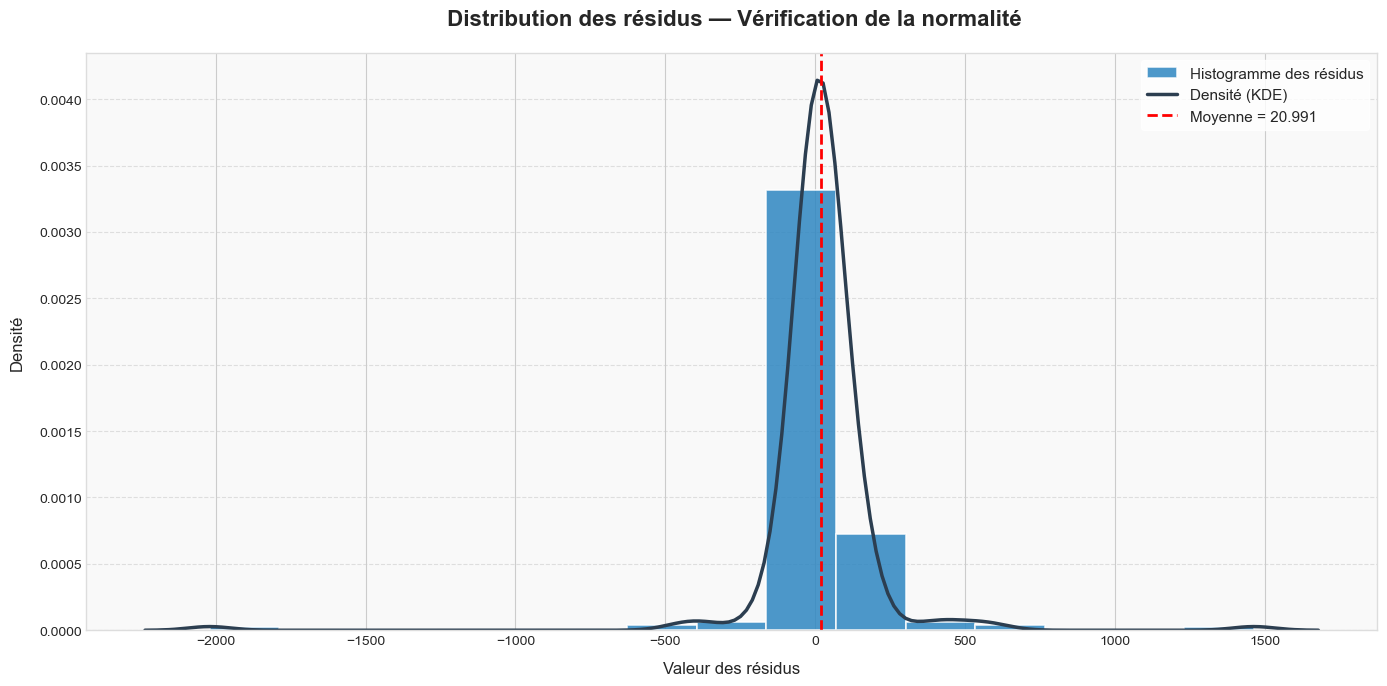

In [63]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

plt.figure(figsize=(14, 7))

n, bins, patches = plt.hist(residus.dropna(), 
                            bins=15, 
                            color='#2E86C1', 
                            edgecolor='white', 
                            linewidth=1.2, 
                            alpha=0.85, 
                            density=True, 
                            label='Histogramme des résidus')

sns.kdeplot(residus.dropna(), color='#2C3E50', linewidth=2.5, label='Densité (KDE)')

mean_resid = residus.mean()
plt.axvline(mean_resid, color='red', linestyle='--', linewidth=2, 
            label=f'Moyenne = {mean_resid:.3f}')

plt.title(" Distribution des résidus — Vérification de la normalité", 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Valeur des résidus", fontsize=12, labelpad=10)
plt.ylabel("Densité", fontsize=12, labelpad=10)

plt.legend(fontsize=11, frameon=True, facecolor='white', edgecolor='white')

plt.grid(True, linestyle='--', alpha=0.6, axis='y')
plt.gca().set_facecolor('#F9F9F9')
for spine in plt.gca().spines.values():
    spine.set_color('#DDDDDD')

plt.tight_layout()
plt.show()

**H0 : la série suit une loi normale**

**H1 : la série ne suit pas une loi normale**

In [70]:
if len(residus.dropna()) < 5000:
    stat, p_value = shapiro(residus.dropna())
    print(f"\n Test de Shapiro-Wilk de normalité :")
    print(f"Statistique = {stat:.4f}, p-value = {p_value:.4f}")
    if p_value > 0.05:
        print(" Les résidus suivent probablement une loi normale (non-rejet de H₀)")
    else:
        print(" Les résidus ne suivent probablement pas une loi normale (rejet de H₀)")


 Test de Shapiro-Wilk de normalité :
Statistique = 0.4574, p-value = 0.0000
 Les résidus ne suivent probablement pas une loi normale (rejet de H₀)


### **- La moyenne des erreurs de prédiction**

In [65]:
round(residus.mean(),2)

20.99

# **V- PREVISION**

### **- Prévision et visualisation sans intervalle de confiance**

In [66]:
model = ExponentialSmoothing(
    a,
    trend='add',
    seasonal=None,
    initialization_method='estimated'
)

fitted_model = model.fit()

prev = fitted_model.forecast(steps=4)

print("📈 Prévisions (sans intervalle de confiance) :")
print(prev)

📈 Prévisions (sans intervalle de confiance) :
2024-06-30    28641.176139
2024-09-30    29006.141276
2024-12-31    29371.106412
2025-03-31    29736.071549
Freq: QE-DEC, dtype: float64


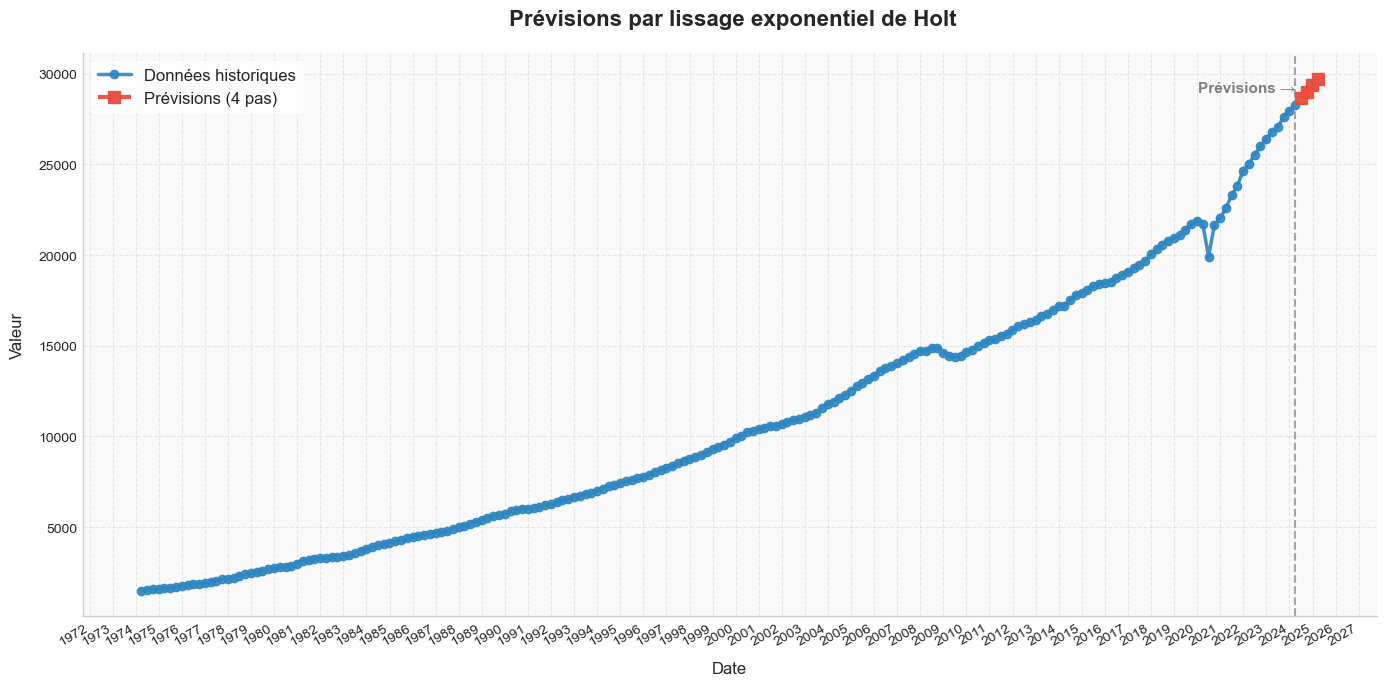

In [67]:
historique = a
prev_series = prev 

plt.figure(figsize=(14, 7))

plt.plot(historique.index, historique,
         color='#2E86C1', linewidth=2.5, marker='o', markersize=6,
         label='Données historiques', alpha=0.9)

plt.plot(prev_series.index, prev_series,
         color='#E74C3C', linewidth=3.0, marker='s', markersize=8,
         label='Prévisions (4 pas)', linestyle='--', alpha=0.95)

plt.axvline(x=historique.index[-1], color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.text(historique.index[-1], plt.ylim()[1]*0.95, 'Prévisions →',
         ha='right', va='top', fontsize=11, color='gray', fontweight='bold')

plt.title(" Prévisions par lissage exponentiel de Holt", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Date", fontsize=12, labelpad=10)
plt.ylabel("Valeur", fontsize=12, labelpad=10)

plt.grid(True, linestyle='--', alpha=0.6, color='#D5DBDB')
plt.gca().set_facecolor('#F9F9F9')

plt.legend(loc='upper left', frameon=True, facecolor='white', edgecolor='white', fontsize=12)

if isinstance(a.index, pd.DatetimeIndex):
    import matplotlib.dates as mdates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gcf().autofmt_xdate()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### **- Prévision et visualisation avec intervalle de confiance**

In [68]:
model = ExponentialSmoothing(
    a,
    trend='add',
    seasonal=None,
    initialization_method='estimated'
)
fitted_model = model.fit()

steps = 4

forecast = fitted_model.forecast(steps)

residuals = fitted_model.resid
sigma = np.sqrt(np.mean(residuals**2))

h = np.arange(1, steps + 1)
se_forecast = sigma * np.sqrt(h)

z = norm.ppf(0.975)
lower = forecast - z * se_forecast
upper = forecast + z * se_forecast

if isinstance(a.index, pd.DatetimeIndex):
    freq = a.index.freq or pd.infer_freq(a.index)
    if freq is None:
        freq = 'Q' 

    last_date = a.index[-1]
    future_dates = pd.date_range(start=last_date, periods=steps + 1, freq=freq)[1:] 
    forecast.index = future_dates
    lower.index = future_dates
    upper.index = future_dates

print("📈 Prévisions avec intervalle de confiance :")
for date, f, l, u in zip(forecast.index, forecast, lower, upper):
    print(f"{date.strftime('%Y-%m-%d')}: {f:.2f}  (95% CI: {l:.2f} – {u:.2f})")

📈 Prévisions avec intervalle de confiance :
2024-06-30: 28641.18  (95% CI: 28233.98 – 29048.37)
2024-09-30: 29006.14  (95% CI: 28430.28 – 29582.01)
2024-12-31: 29371.11  (95% CI: 28665.82 – 30076.40)
2025-03-31: 29736.07  (95% CI: 28921.67 – 30550.47)


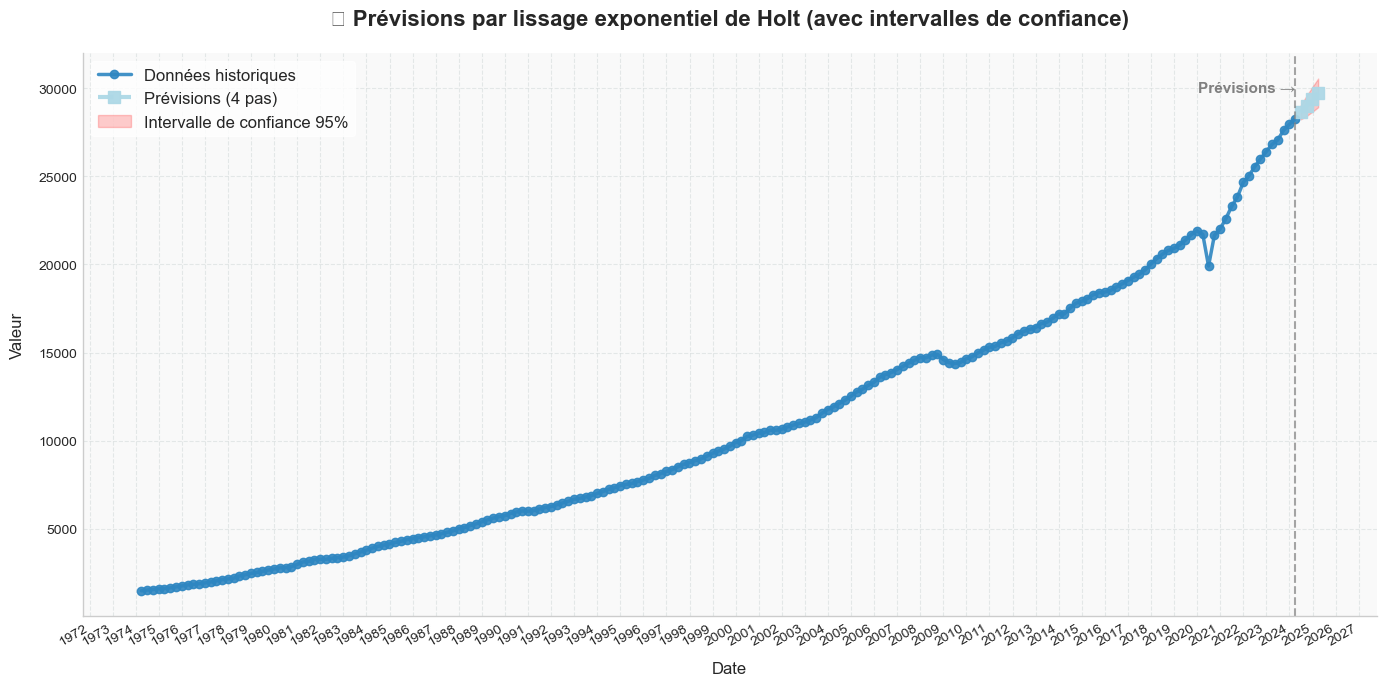

In [69]:
historique = a
prev_series = prev
lower_series = lower
upper_series = upper

plt.figure(figsize=(14, 7))

plt.plot(historique.index, historique,
         color='#2E86C1', linewidth=2.5, marker='o', markersize=6,
         label='Données historiques', alpha=0.9)

plt.plot(prev_series.index, prev_series,
         color='lightblue', linewidth=3.0, marker='s', markersize=8,
         label='Prévisions (4 pas)', linestyle='--', alpha=0.95)

plt.fill_between(prev_series.index,
                 lower_series,
                 upper_series,
                 color='red', alpha=0.2, label='Intervalle de confiance 95%')

plt.axvline(x=historique.index[-1], color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.text(historique.index[-1], plt.ylim()[1]*0.95, 'Prévisions →',
         ha='right', va='top', fontsize=11, color='gray', fontweight='bold')

plt.title("📈 Prévisions par lissage exponentiel de Holt (avec intervalles de confiance)", 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Date", fontsize=12, labelpad=10)
plt.ylabel("Valeur", fontsize=12, labelpad=10)

plt.grid(True, linestyle='--', alpha=0.6, color='#D5DBDB')
plt.gca().set_facecolor('#F9F9F9')

plt.legend(loc='upper left', frameon=True, facecolor='white', edgecolor='white', fontsize=12)

if isinstance(a.index, pd.DatetimeIndex):
    import matplotlib.dates as mdates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gcf().autofmt_xdate()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### **CONCLUSION**
Au regard du graphique des résidus, il semble plausible que les erreurs de prévision aient une variance constante 
dans le temps. 
Le test de bruit blanc est convaincant
À partir de l'histogramme des erreurs de prévision, il semble plausible que les erreurs de prévision soient 
normalement réparties de moyenne zéro. Mais le test de normalité nous indique que la série ne suit pas une loi 
normale
Les erreurs ne sont pas centrées (moyenne nulle) 
Le modèle est certes acceptable car les résidus sont un bruit blanc mais peut 
être amélioré car ce n’est pas un blanc gaussien et centré.

# **CONCLUSION GENERALE**
**Dans cette étude, nous avons cherché à savoir si le PIB suffit vraiment à mesurer la santé d’un pays. Nos résultats montrent que la méthode du lissage exponentiel capture bien l’évolution du PIB américain, avec une marge d’erreur raisonnable et des résidus qui ressemblent à du bruit blanc. Même si ces résidus ne suivent pas une distribution parfaitement normale, le modèle reste fiable pour faire des prévisions. Par exemple, voici les estimations du PIB américain pour les prochains trimestres, avec un niveau de confiance de 95% : environ 28 641 pour fin juin 2024, 29 006 pour fin septembre 2024, 29 371 pour fin décembre 2024, et 29 736 pour fin mars 2025.**

**Depuis plusieurs années, le PIB des États-Unis a connu une belle croissance grâce à des réformes économiques profondes. Malgré des obstacles internes et externes, le pays a réussi à relancer son économie par des politiques solides qui ont favorisé différents secteurs. Cela confirme que la croissance du PIB reste un bon indicateur pour évaluer la santé économique globale d’un pays.**

**Cependant, pour vraiment comprendre ce que signifie cette croissance, il serait intéressant d’aller plus loin en intégrant des données sociales, comme le niveau de vie ou la répartition des salaires. Cela permettrait de voir si cette augmentation du PIB se traduit par un meilleur bien-être pour tous et une répartition équitable des richesses. Une telle approche pourrait nous aider à mieux mesurer la performance réelle d’une économie, au-delà des simples chiffres.**

###### Did by : Onesime-ndri